# Finbert

#### Importing model - [FinBert](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3910214)

In [1]:
# Import all the necessary packages.
!pip install transformers
!pip install torch torchvision torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers
import nltk
nltk.download('punkt')

from transformers import BertTokenizer, BertForSequenceClassification

print(transformers.__version__)
print(torch.__version__)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\burts\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


4.39.1
2.2.1+cpu


#### Importing text

In [2]:
# Import the data set. We will use the less normalised Vader data set which has been copied into a new .csv. 
speech_finbert = pd.read_csv('speech_bert_1.csv')

Unlike with previous models, FinBert was trained on Financial Corpora which include:

- Corporate Reports 10-K & 10-Q: 2.5B tokens 
 
- Earnings Call Transcripts: 1.3B tokens 
 
- Analyst Reports: 1.1B tokens 

This means that it will be run on the un normalised "text" column to ensure accuracy is maintained. 

In [3]:
speech_finbert.head()

,reference,country,date,title,author,is_gov,text,Body,central_bank,year,language,clean_text
0,r980915a_BOE,United Kingdom,1998-09-15,Speech,George,False,"Thank you, Chairman. I'm actually very pleased...",BOE,Bank of England,1998,en,thank chairman actually pleased opportunity re...
1,r981021b_BOE,United Kingdom,1998-10-21,Britain in Europe,George,False,It's a great pleasure to be here in the beauti...,BOE,Bank of England,1998,en,great pleasure beautiful city bruges honoured ...
2,r981021a_BOE,United Kingdom,1998-10-21,Impact of the recent turbulence in internation...,King,True,Few industries have suffered more from volatil...,BOE,Bank of England,1998,en,industries suffered volatility british economy...
3,r981101a_BOE,United Kingdom,1998-11-01,"Economic policy, with and without forecasts",Budd,False,My topic this evening is the use of forecasts ...,BOE,Bank of England,1998,en,topic evening use forecasts economic general u...
4,r981101b_BOE,United Kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,Vickers,False,"Six years ago this week, sterling left the exc...",BOE,Bank of England,1998,en,six years ago week sterling left exchange rate...


## Sentiment Analysis

#### Text Chunking to Handle BERT Token Limit

BERT models have a token limit of 512. We will write a function to chunk the text appropriately.

In [4]:
from nltk.tokenize import sent_tokenize

def chunk_text(text, max_length=510):  # Reserve 2 tokens for special tokens
    """
    Splits text into BERT-compatible chunks.
    """
    # Tokenize the text into sentences.
    sentences = sent_tokenize(text)
    current_chunk = []
    chunks = []
    
    for sentence in sentences:
        if len(current_chunk) + len(sentence.split()) <= max_length:
            current_chunk.extend(sentence.split())
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = sentence.split()
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    return chunks

#### Setting Up FinBERT

FinBERT is a pre-trained model by Hugging Face, tailored for financial sentiment analysis. We'll load the model and tokenizer.

In [5]:
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

#### Applying FinBERT to Chunked Text

In [6]:
# Define the analyse_sentiment function
def analyse_sentiment(text):
    model.eval()
    chunks = chunk_text(text)
    sentiments = []
    
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiments.append(predictions.detach().numpy()[0])
    
    avg_sentiments = np.mean(sentiments, axis=0)
    sentiment_series = pd.Series(avg_sentiments, index=['neutral', 'positive', 'negative'])
    polarity_score = sentiment_series['positive'] - sentiment_series['negative']
    sentiment_series['polarity_score'] = polarity_score
    
    return sentiment_series

The Sentiment Analysis function does the following things:

Chunking the Text: 
- Divides the input text into smaller chunks to fit the model's maximum input size.

Processing Each Chunk:
- Tokenisation: Converts text chunks into a format suitable for the model using the tokeniser.
- Model Inference: Passes tokenized input through the model to obtain sentiment scores.
- Softmax Application: Converts raw scores into probabilities using softmax function.
- Aggregating Sentiment Scores: Averages sentiment probabilities across all chunks to represent overall sentiment.

Calculating Polarity Score: 
- Computes a single polarity score as the difference between positive and negative sentiment probabilities, providing a summary sentiment metric.

In [7]:
# Confirm the order of sentiment output is 'neutral', 'positive', 'neegative'. 

#Option 1: Inspect model configuration

from transformers import AutoModelForSequenceClassification

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Attempt to find label mappings
if model.config.id2label:
    print("Label mapping found:", model.config.id2label)
else:
    print("Label mapping not explicitly defined in this model's configuration.")

Label mapping found: {0: 'Neutral', 1: 'Positive', 2: 'Negative'}


> [Here is official documentation suggesting the order of the outputs are 0:'neutral', 1:'positive',2:'negative' as well](https://github.com/yya518/FinBERT) As such we will define our outputs accordingly.

In [8]:
# Option 2a: Test out a sentence to sense check our understanding of order (positive sentence)

def analyse_sentiment_test(text):
    model.eval()
    # Directly tokenize the text without chunking
    inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiments = predictions.detach().numpy()
    
    # Calculate the average of the sentiments directly from the predictions
    avg_sentiments = np.mean(sentiments, axis=0)
    
    # Print the average sentiments
    print(avg_sentiments)

# Specify the text you want to analyze
text = "The Bank of England are optimistic about the UK's economic outlook."

# Call the analyse_sentiment function with the specified text
analyse_sentiment_test(text)

[3.2756287e-08 1.0000000e+00 2.2150109e-08]


The output shows 0.0000032756411% probability of neutrality, 100% probability of positivity, and 0.0000022150193% probability of negativity. This is in line with our understanding of the order of sentiment. Let's try a clearly negative statement also, and analyse the results

In [9]:
# Option 2b: Test out a sentence to sense check our understanding of order (negative sentence)

def analyse_sentiment_test(text):
    model.eval()
    # Directly tokenize the text without chunking
    inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiments = predictions.detach().numpy()
    
    # Calculate the average of the sentiments directly from the predictions
    avg_sentiments = np.mean(sentiments, axis=0)
    
    # Print the average sentiments
    print(avg_sentiments)

# Specify the text you want to analyze
text = "The Bank of England are worried about the UK's economic outlook."

# Call the analyse_sentiment function with the specified text
analyse_sentiment_test(text)

[2.5969535e-07 7.0430048e-09 9.9999976e-01]


The output shows 0.00002597%. probability of neutrality, 0.0000007043%. probability of positivity, and 99.999976% probability of negativity. This is in line with our understanding of the order of sentiment. 

Through the model's configuration and testing of sentences, we are confident that the order of sentiment output is neutral, positive, and negative. 

# Analysing Sentiments of the Dataset

In [10]:
# As it's a long calcualtion a progress bar is a useful measure. 
from tqdm import tqdm

# Enable tqdm progress bar for pandas apply
tqdm.pandas()

Now we have "analyse_sentiment" that returns the sentiment scores in the form [neutral, positive, negative] for a given text, we can loop through each text, apply analyse_sentiment, then calculate the polarity score using calculate_polarity. Finally, we'll store these polarity scores in a new column.

In [11]:
# Apply the analyse_sentiment function to the first 10 entries of the dataset
# finbert_polarity = speech_finbert['text'].head(10).progress_apply(analyse_sentiment)

In [12]:
# Expanding the results into the original DataFrame
# speech_finbert[['neutral', 'positive', 'negative', 'polarity_score']] = finbert_polarity

In [13]:
# speech_finbert.head(10)

Now we create a function that calculates the polarity score based on the sentiment analysis results:

In [14]:
# Apply the analyse_sentiment function to the all  entries of the dataset
finbert_polarity = speech_finbert['text'].progress_apply(analyse_sentiment)

  0%|          | 3/1209 [00:44<5:00:46, 14.96s/it]


KeyboardInterrupt: 

In [ ]:
# Expanding the results into the original DataFrame
speech_finbert[['neutral', 'positive', 'negative', 'polarity_score']] = finbert_polarity

In [ ]:
speech_finbert.head(15)

In [ ]:
# Renaming the finbert_compound to vader_polarity for consistency with other models. 
speech_finbert = speech_finbert.rename(columns={'polarity_score': 'finbert_polarity'})

In [ ]:
# Renaming the neu, pos, neg columns for consistency with other models. 
speech_finbert = speech_finbert.rename(columns={'neutral': 'finbert_neutral', 'positive': 'finbert_positive', 'negative': 'finbert_negative',  })

In [ ]:
speech_finbert.head(15)

In [ ]:
# Export DataFrame to CSV
# speech_finbert.to_csv('finbert_scores.csv', index=False)

In [ ]:
# Histogram for speech_vader_compound
plt.figure(figsize=(10, 5))
plt.hist(
    speech_finbert['finbert_polarity'],
    bins=34,
    alpha=0.7,
    color='blue',
    label='Speech Fibert Compound scores'
)
plt.title('Finbert Sentiment Scorre Distribution)
plt.xlabel('finbert_polarity')
plt.ylabel('Count')
plt.legend()
plt.show()

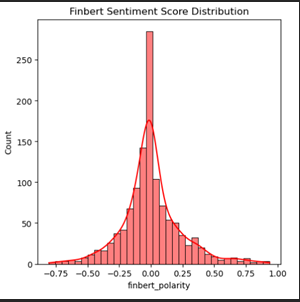

- Finbert shows a strong and healthy curve around the expected netural of a central bank's communication style. As such this will be our model choicie.

In [ ]:
speech_finbert['finbert_polarity'].describe()

- Mean: The average sentiment score is very close to zero (0.005142), indicating that overall sentiment across all speeches is almost neutral.
- Standard Deviation: A relatively high standard deviation (0.234896) suggests there's considerable variability in sentiment scores.
- Minimum: The most negative sentiment score is quite low (-0.805046), showing that there have been instances of strongly negative sentiment.
- 25th Percentile: 25% of the scores are lower than -0.105807, which could be considered mildly negative.
- Median (50th Percentile): The median sentiment score is slightly negative (-0.004519), reinforcing the mean's indication of a general tilt towards neutral sentiment.
- 75th Percentile: 75% of the scores are below 0.093910, indicating that more positive sentiments are not as extreme as the negative ones.
- Maximum: The most positive sentiment score is very high (0.938213), showing that there have also been instances of strongly positive sentiment